In [1]:
import utils
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
test_csv = 'CheXpert-v1.0-small/valid.csv'
saved_model_path = 'chexpert_224x224_weighted_loss_tpu.h5'

In [3]:
labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

In [4]:
test_df = pd.read_csv(test_csv)

test_images = test_df.Path.values
gt_labels = test_df[labels].values

In [5]:
image_list = []
for filename in test_images:
    image_bytes = tf.io.read_file(filename)
    image_array = tf.image.decode_jpeg(image_bytes, channels=3)
    image_float = tf.image.convert_image_dtype(image_array, tf.float32)
    resized_img = tf.image.resize(image_float, [224, 224])
    norm_image = utils.normalize_image(resized_img)
    image_list.append(norm_image)

image_batch = tf.stack(image_list)

In [6]:
loaded_model = tf.keras.models.load_model(saved_model_path, compile=False)
predictions = loaded_model.predict(image_batch)

In [7]:
def get_roc_curve(labels, predicted_vals, gt_labels):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = gt_labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(5, 5))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

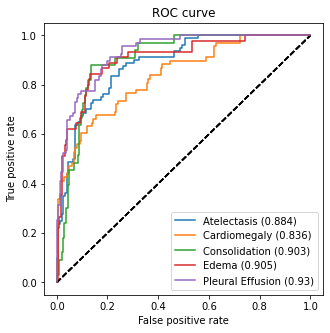

In [8]:
auc_rocs = get_roc_curve(labels, predictions, gt_labels)